In [1]:
import re
import pandas as pd
import numpy as np
import os
import seaborn as sns
import h5py
import scipy.stats
import random
from matplotlib.pyplot import *
from statsmodels.nonparametric import smoothers_lowess
import statsmodels.stats.multitest
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import glob


sns.set_style("ticks")
%matplotlib inline

In [2]:
mapping_df = pd.read_csv('/nfs/leia/research/stegle/dseaton/genomes/hg19/annotation/geneid_mappings/ensembl_gene_id2hgnc_symbol.txt',
                        sep='\t')
mapping_df.head()

,ensembl_gene_id,hgnc_symbol
0,ENSG00000261657,SLC25A26
1,ENSG00000223116,NaN
2,ENSG00000233440,HMGA1P6
3,ENSG00000207157,RNY3P4
4,ENSG00000229483,LINC00362


In [3]:
file_template = '/nfs/leia/research/stegle/dseaton/hipsci/singlecell_neuroseq/data/data_processed/pool1_17_D52/pool1_17_D52.scanpy.w_metadata.w_celltype.scanpy.obs_df.groupedby.donor_id-pool_id-time_point.celltype_counts.tsv'
timepoints = ['D52']

list_of_dfs = []
for timepoint in timepoints:
    df = pd.read_csv(file_template.format(timepoint=timepoint), sep='\t')
    list_of_dfs.append(df)

df2 = pd.concat(list_of_dfs, axis=0)

#clusters = [0,1,2,3]
#### limit only to clusters 0,1,2,3 in any timepoint
#df2  = df2.query('celltype in @clusters')

# relabel clusters by timepoint
df2['celltype'] = df2['celltype'] + '_' + df2['time_point'].astype(str)
df2.head()

,donor_id,pool_id,time_point,celltype,n_cells
0,HPSI0114i-bezi_3,pool10,D52,Astro_D52,6
1,HPSI0114i-bezi_3,pool10,D52,CHem_D52,6
2,HPSI0114i-bezi_3,pool10,D52,DA_D52,103
3,HPSI0114i-bezi_3,pool10,D52,Epen1_D52,79
4,HPSI0114i-bezi_3,pool10,D52,FPP_D52,64


In [4]:
df3 = df2.set_index(['donor_id','pool_id'])[['celltype','n_cells']]
df3 = df3.pivot(columns='celltype')

df3.columns = df3.columns.get_level_values(1)

#column_order = ['P_FPP_D11','FPP_D11','NB_D11','Astro_D30','Astro_D52','Epen1_D30','Epen1_D52','Sert_D30','Sert_D52','DA_D30','DA_D52','CHem_D52']
#df3 = df3[column_order]


# df3 = df3.fillna(0.0)
print(df3.shape)
df3.head()



(232, 10)


celltype                  Astro_D52  CHem_D52  DA_D52  Epen1_D52  Epen2_D52  \
donor_id         pool_id                                                      
HPSI0114i-bezi_3 pool10         6.0       6.0   103.0       79.0        NaN   
HPSI0114i-eipl_1 pool1      13277.0    2346.0   248.0     3583.0       80.0   
HPSI0114i-fikt_3 pool14        33.0       4.0    67.0       62.0        4.0   
HPSI0114i-kolf_2 pool10         1.0       NaN    52.0       78.0        9.0   
                 pool15       315.0     550.0   883.0      192.0        9.0   

celltype                  FPP_D52  P_FPP_D52  P_Sert_D52  Sert_D52  \
donor_id         pool_id                                             
HPSI0114i-bezi_3 pool10      64.0        4.0         5.0     126.0   
HPSI0114i-eipl_1 pool1     4095.0     2067.0         5.0      86.0   
HPSI0114i-fikt_3 pool14      47.0        6.0         NaN      47.0   
HPSI0114i-kolf_2 pool10      24.0        NaN         1.0      70.0   
                 pool15     180.0       96.0         1.0     181.0   

celltype                  unknown_D52  
donor_id         pool_id               
HPSI0114i-bezi_3 pool10           NaN  
HPSI0114i-eipl_1 pool1          148.0  
HPSI0114i-fikt_3 pool14          13.0  
HPSI0114i-kolf_2 pool10           8.0  
                 pool15          16.0

In [5]:
df4 = df3.reset_index().groupby('donor_id').sum()
df4.head()

celltype,Astro_D52,CHem_D52,DA_D52,Epen1_D52,Epen2_D52,FPP_D52,P_FPP_D52,P_Sert_D52,Sert_D52,unknown_D52
donor_id,,,,,,,,,,
HPSI0114i-bezi_3,6.0,6.0,103.0,79.0,0.0,64.0,4.0,5.0,126.0,0.0
HPSI0114i-eipl_1,13277.0,2346.0,248.0,3583.0,80.0,4095.0,2067.0,5.0,86.0,148.0
HPSI0114i-fikt_3,33.0,4.0,67.0,62.0,4.0,47.0,6.0,0.0,47.0,13.0
HPSI0114i-kolf_2,316.0,550.0,935.0,270.0,18.0,204.0,96.0,2.0,251.0,24.0
HPSI0114i-lexy_2,24.0,1.0,144.0,58.0,2.0,168.0,24.0,17.0,627.0,11.0


In [6]:
df5 = df3.fillna(0.0).sum(axis=1).reset_index()
df5.columns = ['donor_id','pool_id','n_cells']

tot_cells = df5.groupby('donor_id').sum()

tot_cells = tot_cells.rename(columns={'n_cells':'tot_cells'})

print(tot_cells.shape)
tot_cells.head()

(199, 1)


,tot_cells
donor_id,
HPSI0114i-bezi_3,393.0
HPSI0114i-eipl_1,25935.0
HPSI0114i-fikt_3,283.0
HPSI0114i-kolf_2,2666.0
HPSI0114i-lexy_2,1076.0


Text(0.5, 0, 'Total number of cells at D52')

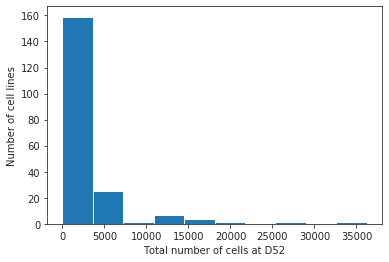

In [7]:
hist(tot_cells['tot_cells'])
ylabel('Number of cell lines')
xlabel('Total number of cells at D52')

In [ ]:
name = "All cells"

df4 = df3.dropna().sum(axis=1).reset_index()
df4.columns = ['donor_id','pool_id','n_cells']

donor_counts = df4['donor_id'].value_counts()
selected_donors = donor_counts[donor_counts==2].index

df4 = df4.query('donor_id in @selected_donors').set_index('donor_id')

In [21]:
df4.head()

,pool_id,n_cells
donor_id,,
HPSI0115i-hecn_6,pool2,2071.0
HPSI0115i-hecn_6,pool3,1132.0
HPSI0115i-tiku_3,pool17,993.0
HPSI0115i-tiku_3,pool9,206.0
HPSI0214i-pelm_3,pool2,6829.0


In [2]:
x_data = []
y_data = []
for donor in selected_donors:
    data = df4.loc[donor, 'n_cells']
    x_data.append(data.iloc[0])
    y_data.append(data.iloc[1])

NameError: name 'selected_donors' is not defined

In [4]:
fig = figure(figsize=(4.5,4))
FS = 18

# plot([0.0,1.0],[0.0,1.0],'k--')
plot(x_data,y_data,'o',color='mediumseagreen')
R,p = scipy.stats.pearsonr(x_data,y_data)
text(6000,8000,s='R={:.2f}'.format(R),fontsize=24)
print(R,p,R*R)
xlim([0,10000])
ylim([0,10000])
xlabel('Number of cells\n(replicate 1)'.format(name), fontsize=FS)
ylabel('Number of cells\n(replicate 2)'.format(name), fontsize=FS)
title(name, fontsize=FS+4)

# fig.savefig('../../figures/differentiation_trajectories_{}_replication.png'.format(name),
#            dpi=120, bbox_inches='tight')


print('')

NameError: name 'figure' is not defined

In [8]:
#t_file = '/nfs/leia/research/stegle/dseaton/hipsci/proteomics_analysis/data/analysis/IPSc.ISR.featureCounts.genes.counts.unique.stranded.tsv_counts.HQ_TMM_TPM.tsv.gz'
t_file = '/hps/nobackup/hipsci/scratch/trans_eqtls/IPS_Bulk-RNA_Processing/Merged/IPS_Bulk-RNA_Processing/FullFreeze_Corrected_iPSC_20180506.txt.gz'

t_df = pd.read_csv(t_file,
                  sep='\t', index_col=0)

t_df.columns = [x.replace('i.','i-').replace('.hs37d5','') for x in t_df.columns]

t_df = t_df.loc[:, [x.startswith('HPSI') for x in t_df.columns]]
t_df = t_df[t_df.mean(axis=1)>2.0]


print(t_df.shape)

t_df.head()

(15456, 815)


,HPSI0114i-bezi_1,HPSI0114i-bezi_3,HPSI0114i-eipl_1,HPSI0114i-eipl_3,HPSI0114i-fikt_3,HPSI0114i-iisa_1,HPSI0114i-iisa_3,HPSI0114i-joxm_1,HPSI0114i-kolf_2,HPSI0114i-kolf_3,...,HPSI1213i-babk_2,HPSI1213i-foqj_2,HPSI1213i-hehd_1,HPSI1213i-hehd_2,HPSI1213i-nekd_1,HPSI1213i-pahc_4,HPSI1213i-pahc_5,HPSI1213i-tolg_4,HPSI1213i-tolg_6,HPSI1213i-xuja_2
ENSG00000227232,5.949736,5.804228,5.998296,6.103528,5.313150,5.367878,5.645318,5.997725,5.633292,6.273985,...,5.757756,6.030894,5.526627,5.627544,5.806231,6.285153,5.779463,5.313008,5.632988,6.268481
ENSG00000237683,4.306061,4.761132,5.269492,5.226469,4.602607,4.579685,4.921617,5.189938,5.481510,5.181876,...,4.605153,5.475678,4.386556,5.039847,5.455942,5.497346,4.544433,4.514377,5.182108,5.032693
ENSG00000239906,3.440319,4.335320,4.907799,5.258379,3.995890,4.657899,5.363874,4.158991,4.831910,5.100670,...,4.207819,5.212017,4.277409,5.061932,5.800246,5.866232,4.770117,4.493827,6.102605,4.447120
ENSG00000241860,1.845949,1.874849,2.453120,2.356231,1.928637,1.716941,1.898862,2.192841,2.360707,2.436328,...,1.758515,2.389833,1.973546,2.325539,2.229093,2.353388,1.600736,1.971813,2.494855,1.967695
ENSG00000237094,2.396015,2.512063,3.003918,2.808671,2.560465,2.590156,2.923498,2.891094,3.089073,3.233248,...,2.621237,2.990237,2.349560,2.705635,2.828586,3.426813,2.852307,2.730802,3.041198,3.045552


In [34]:
df_temp = t_df.transpose()

all_data_df = tot_cells.join(df_temp).dropna()

all_data_df['tot_cells_shuffled'] = random.sample(all_data_df['tot_cells'].tolist(), all_data_df.shape[0])

all_data_df.head()

,tot_cells,ENSG00000227232,ENSG00000237683,ENSG00000239906,ENSG00000241860,ENSG00000237094,ENSG00000250575,ENSG00000225972,ENSG00000225630,ENSG00000237973,...,MER44D,MER39,PRIMA4_LTR,L1ME5,MER39B,ERV3-16A3_LTR,LTR16A2,MLT1H1,MER61C,tot_cells_shuffled
donor_id,,,,,,,,,,,,,,,,,,,,,
HPSI0114i-bezi_3,393.0,5.804228,4.761132,4.335320,1.874849,2.512063,2.154982,8.283441,9.953019,10.512310,...,1.378713,2.506966,3.141230,2.001309,2.471127,1.796884,3.250741,1.272656,2.805709,36228.0
HPSI0114i-eipl_1,25935.0,5.998296,5.269492,4.907799,2.453120,3.003918,1.939940,8.587672,9.885037,10.732276,...,2.604790,1.350376,0.440409,2.215297,1.768005,2.563775,2.329482,1.321476,1.576506,931.0
HPSI0114i-fikt_3,283.0,5.313150,4.602607,3.995890,1.928637,2.560465,2.042237,8.260086,9.790308,10.355640,...,2.376054,1.187677,0.667849,1.731880,2.653027,2.129439,1.581050,1.661422,2.458173,5196.0
HPSI0114i-kolf_2,2666.0,5.633292,5.481510,4.831910,2.360707,3.089073,2.904617,8.919073,10.093396,10.654487,...,1.668907,1.581961,0.689160,0.774205,2.358038,1.789823,2.627532,0.974056,2.608999,155.0
HPSI0114i-lexy_2,1076.0,5.389376,5.102363,4.349743,1.812663,2.745216,2.334497,9.130353,10.546636,10.682291,...,1.351962,1.275082,3.145830,1.496325,3.061517,2.248316,2.229404,0.425940,1.493959,117.0


In [10]:
import statsmodels.api as sm

label = 'tot_cells'

diff_data = all_data_df[label]
other_data = all_data_df.drop([label], axis=1)

In [11]:
def calculate_correlation(data):
#     data = sm.add_constant(data.values, prepend=False)
#     res = sm.OLS(diff_data, data).fit()
#     pval = res.pvalues[0]
#     coef = res.params[0]
    coef,pval = scipy.stats.pearsonr(diff_data, data)
    return pd.Series({'coef':coef,'pval':pval})

test_df = other_data.transpose().apply(calculate_correlation, axis=1)

In [17]:
test_df.head()

,ensembl_gene_id,hgnc_symbol,coef,pval,pval_adj
8027,ENSG00000213700,RPL17P50,0.298232,0.000039,0.189567
9742,ENSG00000235162,C12orf75,-0.299069,0.000037,0.189567
7836,ENSG00000165985,C1QL3,0.297073,0.000042,0.189567
11815,ENSG00000171724,VAT1L,-0.286025,0.000083,0.279171
13811,ENSG00000105137,SYDE1,-0.274715,0.000161,0.371838


In [12]:
test_df.index.name = 'ensembl_gene_id'
test_df = test_df.reset_index()

test_df = test_df.join(mapping_df.set_index('ensembl_gene_id'), on='ensembl_gene_id').dropna()

alpha = 0.1
multitest_method = 'fdr_bh'
# multitest_method = 'bonferroni'
# multitest_method = 'fdr_tsbh'


reject,pvals_corrected,alphacSidak,alphacBonf = statsmodels.stats.multitest.multipletests(test_df['pval'], alpha=alpha, method=multitest_method)

test_df['pval_adj'] = pvals_corrected
test_df = test_df.sort_values(by='pval_adj')

test_df = test_df[['ensembl_gene_id','hgnc_symbol','coef','pval','pval_adj']]

# test_df.to_csv('../../data/expression_associations.{}.tsv'.format(label), sep='\t', index=False)

print((test_df['pval_adj']<0.1).sum())

test_df.head(20)

0


,ensembl_gene_id,hgnc_symbol,coef,pval,pval_adj
8027,ENSG00000213700,RPL17P50,0.298232,0.000039,0.189567
9742,ENSG00000235162,C12orf75,-0.299069,0.000037,0.189567
7836,ENSG00000165985,C1QL3,0.297073,0.000042,0.189567
11815,ENSG00000171724,VAT1L,-0.286025,0.000083,0.279171
13811,ENSG00000105137,SYDE1,-0.274715,0.000161,0.371838
10762,ENSG00000159251,ACTC1,-0.274196,0.000166,0.371838
6792,ENSG00000169499,PLEKHA2,0.247891,0.000692,0.450568
6717,ENSG00000104725,NEFL,0.252221,0.000552,0.450568
4629,ENSG00000153162,BMP6,-0.241721,0.000947,0.450568
1108,ENSG00000085552,IGSF9,-0.245605,0.000778,0.450568


In [36]:
label = 'tot_cells_shuffled'

diff_data = all_data_df[label]
other_data = all_data_df.drop([label], axis=1)

def calculate_correlation(data):
    R,p = scipy.stats.pearsonr(diff_data, data)
    return pd.Series({'R':R,'pval':p})

permuted_test_df = other_data.transpose().apply(calculate_correlation, axis=1)

permuted_test_df.index.name = 'ensembl_gene_id'
permuted_test_df = permuted_test_df.reset_index()

permuted_test_df = permuted_test_df.join(mapping_df.set_index('ensembl_gene_id'), on='ensembl_gene_id').dropna()

alpha = 0.1
multitest_method = 'fdr_bh'
# multitest_method = 'bonferroni'
# multitest_method = 'fdr_tsbh'


reject,pvals_corrected,alphacSidak,alphacBonf = statsmodels.stats.multitest.multipletests(permuted_test_df['pval'], alpha=alpha, method=multitest_method)

permuted_test_df['pval_adj'] = pvals_corrected
permuted_test_df = permuted_test_df.sort_values(by='pval_adj')

permuted_test_df = permuted_test_df[['ensembl_gene_id','hgnc_symbol','R','pval','pval_adj']]

# permuted_test_df.to_csv('../../data/expression_associations.{}.tsv'.format(label), sep='\t', index=False)

print((permuted_test_df['pval_adj']<0.1).sum())

permuted_test_df.head()

5


,ensembl_gene_id,hgnc_symbol,R,pval,pval_adj
13922,ENSG00000213988,ZNF90,-0.387944,5.295981e-08,0.000699
3085,ENSG00000246082,NUDT16P1,-0.379983,1.037000e-07,0.000699
13920,ENSG00000184635,ZNF93,-0.329303,5.009337e-06,0.022500
13928,ENSG00000105750,ZNF85,-0.309239,1.943355e-05,0.052373
6388,ENSG00000000003,TSPAN6,0.312153,1.605628e-05,0.052373


In [38]:
test_df.head()

,ensembl_gene_id,hgnc_symbol,coef,pval,pval_adj
8027,ENSG00000213700,RPL17P50,0.298232,0.000039,0.189567
9742,ENSG00000235162,C12orf75,-0.299069,0.000037,0.189567
7836,ENSG00000165985,C1QL3,0.297073,0.000042,0.189567
11815,ENSG00000171724,VAT1L,-0.286025,0.000083,0.279171
13811,ENSG00000105137,SYDE1,-0.274715,0.000161,0.371838


Text(0, 0.5, 'N genes')

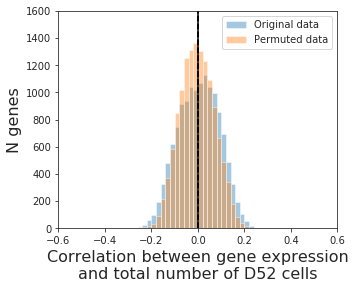

In [44]:
test_df['R'] = test_df['coef']
correlations = test_df['R']
permuted_correlations = permuted_test_df['R']
fdr_threshold = 1
R_threshold = test_df.sort_values(by='pval_adj').query('pval_adj<@fdr_threshold')['R'].iloc[-1]

bins = np.arange(-0.6,0.61,0.02)

fig = figure(figsize=(5,4))
FS = 16
ymax = 1600

#hist(correlations, bins=np.arange(-0.7,0.75,0.1))
sns.distplot(correlations, bins=bins, kde=False, norm_hist=False, label='Original data')
sns.distplot(permuted_correlations, bins=bins, kde=False, norm_hist=False, label='Permuted data')
plot([R_threshold,R_threshold],[0,ymax+100], 'k--')
plot([0,0],[0,ymax+100], 'k-')
plot([-R_threshold,-R_threshold],[0,ymax+100], 'k--')
ylim([0,ymax])
xlim([-0.6,0.6])

legend()

xlabel('Correlation between gene expression\nand total number of D52 cells', fontsize=FS)
ylabel('N genes', fontsize=FS)

In [13]:
gene_list_1 = test_df.query('coef>0')['ensembl_gene_id'].head(10).tolist()
gene_list_2 = test_df.query('coef<0')['ensembl_gene_id'].head(10).tolist()

gene_list = gene_list_1 + gene_list_2

test_df.head(30)

,ensembl_gene_id,hgnc_symbol,coef,pval,pval_adj
8027,ENSG00000213700,RPL17P50,0.298232,0.000039,0.189567
9742,ENSG00000235162,C12orf75,-0.299069,0.000037,0.189567
7836,ENSG00000165985,C1QL3,0.297073,0.000042,0.189567
11815,ENSG00000171724,VAT1L,-0.286025,0.000083,0.279171
13811,ENSG00000105137,SYDE1,-0.274715,0.000161,0.371838
10762,ENSG00000159251,ACTC1,-0.274196,0.000166,0.371838
6792,ENSG00000169499,PLEKHA2,0.247891,0.000692,0.450568
6717,ENSG00000104725,NEFL,0.252221,0.000552,0.450568
4629,ENSG00000153162,BMP6,-0.241721,0.000947,0.450568
1108,ENSG00000085552,IGSF9,-0.245605,0.000778,0.450568
